## 策略思想

以SMA作为开平仓信号，同时增加CCI作为过滤器；  
当股价上穿SMA，同时CCI要小于-100，说明是在超卖的情况下，上穿SMA，做多；交易信号更可信；  
当股价下穿SMA，同时CCI要大于+100，说明是在超买的情况下，下穿SMA，做空；交易信号更可信；

In [1]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保‘-’号显示正常
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

import warnings; warnings.simplefilter('ignore') #忽略可能会出现的警告信息，警告并不是错误，可以忽略；

### 1. 数据准备

In [2]:
# 获取数据
stock_index = ts.get_k_data('hs300', '2017-08-17', '2020-08-17')
stock_index.set_index('date', inplace=True)
stock_index.sort_index(inplace = True)
stock_index.head()

,open,close,high,low,volume,code
date,,,,,,
2017-08-17,3707.07,3721.28,3722.62,3704.41,108656251.0,hs300
2017-08-18,3707.19,3724.67,3733.49,3700.41,96561705.0,hs300
2017-08-21,3731.84,3740.99,3744.26,3728.62,100313073.0,hs300
2017-08-22,3745.75,3752.30,3758.29,3734.56,100292856.0,hs300
2017-08-23,3747.61,3756.09,3772.46,3741.72,104961573.0,hs300


In [3]:
stock_index.index = pd.to_datetime(stock_index.index)

In [4]:
stock_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2017-08-17 to 2020-08-14
Data columns (total 6 columns):
open      729 non-null float64
close     729 non-null float64
high      729 non-null float64
low       729 non-null float64
volume    729 non-null float64
code      729 non-null object
dtypes: float64(5), object(1)
memory usage: 39.9+ KB


In [5]:
# 计算指标sma，cci
stock_index['sma'] = ta.SMA(np.asarray(stock_index['close']), 3)
stock_index['cci'] = ta.CCI(np.asarray(stock_index['high']), np.asarray(stock_index['low']), np.asarray(stock_index['close']), timeperiod=20)

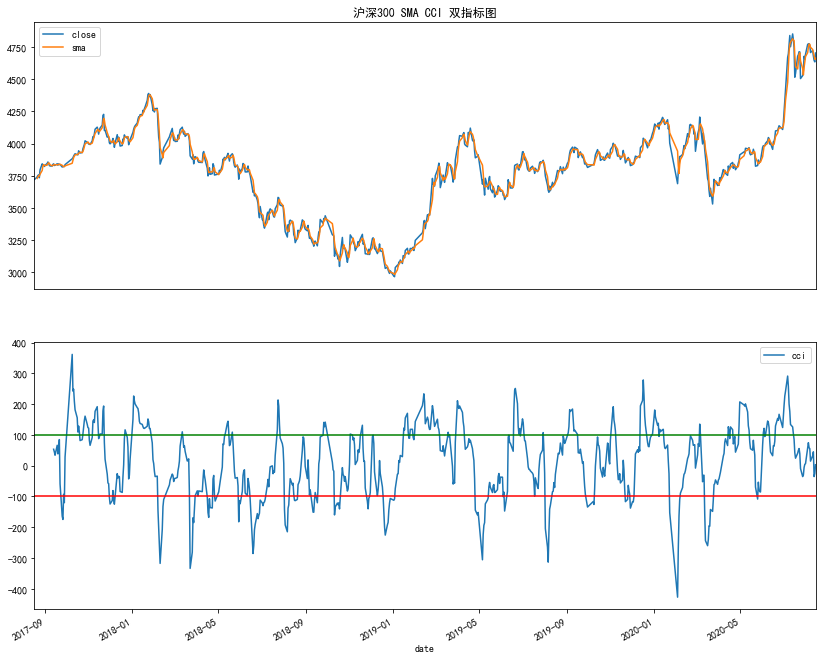

In [6]:
plt.subplot(2,1,1)
plt.title('沪深300 SMA CCI 双指标图')
plt.gca().axes.get_xaxis().set_visible(False)

stock_index['close'].plot(figsize = (14,12))
stock_index['sma'].plot(figsize=(14,12))
plt.legend()

plt.subplot(2,1,2)
stock_index['cci'].plot(figsize = (14,12))
plt.axhline(100, color = 'g')
plt.axhline(-100, color = 'r')
plt.legend()
#plt.show()

### 2. 策略逻辑: 交易信号、持仓信号

#### 2.1 交易信号

In [7]:
# 产生开仓信号时应使用昨日及前日数据，以避免未来数据
stock_index['yes_close'] = stock_index['close'].shift(1)
stock_index['yes_sma'] = stock_index['sma'].shift(1)
stock_index['yes_cci'] = stock_index['cci'].shift(1)   #CCI是作为策略的一个过滤器, 仅需要昨日数据即可；
stock_index['daybeforeyes_close'] = stock_index['close'].shift(2)
stock_index['daybeforeyes_sma'] = stock_index['sma'].shift(2)

In [8]:
stock_index.head()

,open,close,high,low,volume,code,sma,cci,yes_close,yes_sma,yes_cci,daybeforeyes_close,daybeforeyes_sma
date,,,,,,,,,,,,,
2017-08-17,3707.07,3721.28,3722.62,3704.41,108656251.0,hs300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-18,3707.19,3724.67,3733.49,3700.41,96561705.0,hs300,NaN,NaN,3721.28,NaN,NaN,NaN,NaN
2017-08-21,3731.84,3740.99,3744.26,3728.62,100313073.0,hs300,3728.980000,NaN,3724.67,NaN,NaN,3721.28,NaN
2017-08-22,3745.75,3752.30,3758.29,3734.56,100292856.0,hs300,3739.320000,NaN,3740.99,3728.98,NaN,3724.67,NaN
2017-08-23,3747.61,3756.09,3772.46,3741.72,104961573.0,hs300,3749.793333,NaN,3752.30,3739.32,NaN,3740.99,3728.98


In [9]:
# 产生交易信号
# sma开多信号：昨天股价上穿SMA；
stock_index['sma_signal'] = np.where(np.logical_and(stock_index['daybeforeyes_close']<stock_index['daybeforeyes_sma'],
                                                              stock_index['yes_close']>stock_index['yes_sma']), 1, 0)
# sma开空信号：昨天股价下穿SMA
stock_index['sma_signal'] = np.where(np.logical_and(stock_index['daybeforeyes_close']>stock_index['daybeforeyes_sma'],
                                                               stock_index['yes_close']<stock_index['yes_sma']),-1,stock_index['sma_signal'])
# 产生cci做多过滤信号
stock_index['cci_filter'] = np.where(stock_index['yes_cci'] < -100, 1, 0)
# 产生cci做空过滤信号
stock_index['cci_filter']  = np.where(stock_index['yes_cci'] > 100,-1, stock_index['cci_filter'])

# 过滤后的开多信号
stock_index['filtered_signal'] = np.where(stock_index['sma_signal']+stock_index['cci_filter']==2, 1, 0)
# 过滤后的开空信号
stock_index['filtered_signal'] = np.where(stock_index['sma_signal']+stock_index['cci_filter']==-2, -1,stock_index['filtered_signal'])


In [10]:
 stock_index.tail(100)

,open,close,high,low,volume,code,sma,cci,yes_close,yes_sma,yes_cci,daybeforeyes_close,daybeforeyes_sma,sma_signal,cci_filter,filtered_signal
date,,,,,,,,,,,,,,,,
2020-03-20,3629.51,3653.22,3663.95,3588.78,139603000.0,hs300,3626.190000,-142.421809,3589.09,3645.010000,-196.917595,3636.26,3691.260000,0,1,0
2020-03-23,3542.68,3530.31,3585.80,3523.79,137108790.0,hs300,3590.873333,-148.493545,3653.22,3626.190000,-142.421809,3589.09,3645.010000,1,1,1
2020-03-24,3598.65,3625.11,3627.76,3545.45,143103021.0,hs300,3602.880000,-110.087046,3530.31,3590.873333,-148.493545,3653.22,3626.190000,-1,1,0
2020-03-25,3711.48,3722.52,3732.65,3685.99,153495958.0,hs300,3625.980000,-61.931680,3625.11,3602.880000,-110.087046,3530.31,3590.873333,1,1,1
2020-03-26,3692.61,3698.05,3736.25,3681.27,112310665.0,hs300,3681.893333,-58.402518,3722.52,3625.980000,-61.931680,3625.11,3602.880000,0,0,0
2020-03-27,3746.39,3710.06,3758.78,3709.92,124060995.0,hs300,3710.210000,-46.302368,3698.05,3681.893333,-58.402518,3722.52,3625.980000,0,0,0
2020-03-30,3657.46,3674.11,3690.64,3637.59,126876673.0,hs300,3694.073333,-60.690952,3710.06,3710.210000,-46.302368,3698.05,3681.893333,-1,0,0
2020-03-31,3708.14,3686.16,3716.07,3676.20,111453025.0,hs300,3690.110000,-47.043080,3674.11,3694.073333,-60.690952,3710.06,3710.210000,0,0,0
2020-04-01,3682.30,3675.08,3731.78,3670.97,119352620.0,hs300,3678.450000,-42.860329,3686.16,3690.110000,-47.043080,3674.11,3694.073333,0,0,0


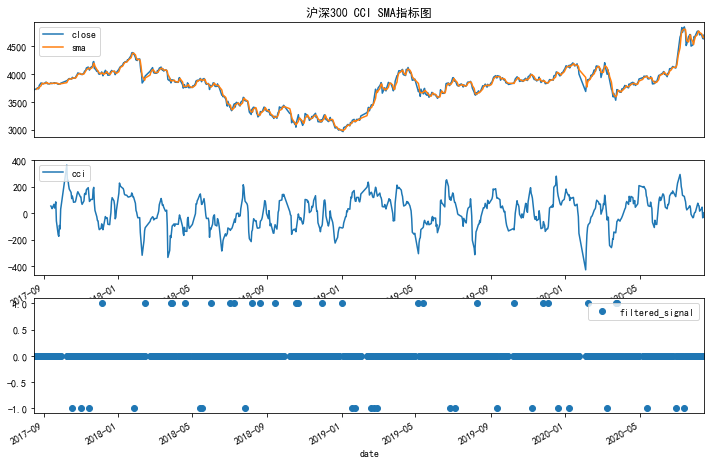

In [11]:
# 绘制cci，sma指标图
plt.subplot(3,1,1)
plt.title('沪深300 CCI SMA指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(12,8))
stock_index['sma'].plot()
plt.legend(loc='upper left')
plt.subplot(3,1,2)
stock_index['cci'].plot(figsize=(12, 8))
plt.legend(loc='upper left')
plt.subplot(3,1,3)
stock_index['filtered_signal'].plot(figsize=(12, 8), marker='o', linestyle='')
plt.legend(loc='upper right')
plt.show()

#### 2.2 持仓信号

In [12]:
position = 0

for i, items in stock_index.iterrows():
    
    if items['filtered_signal'] == 1:
        position = 1
    elif items['filtered_signal'] == -1:
        position = -1
    else:
        pass
    stock_index.loc[i, 'position'] = position
# 1.not stock_index['items']['filtered_signal']
# 2.don't forget stock_index.LOC

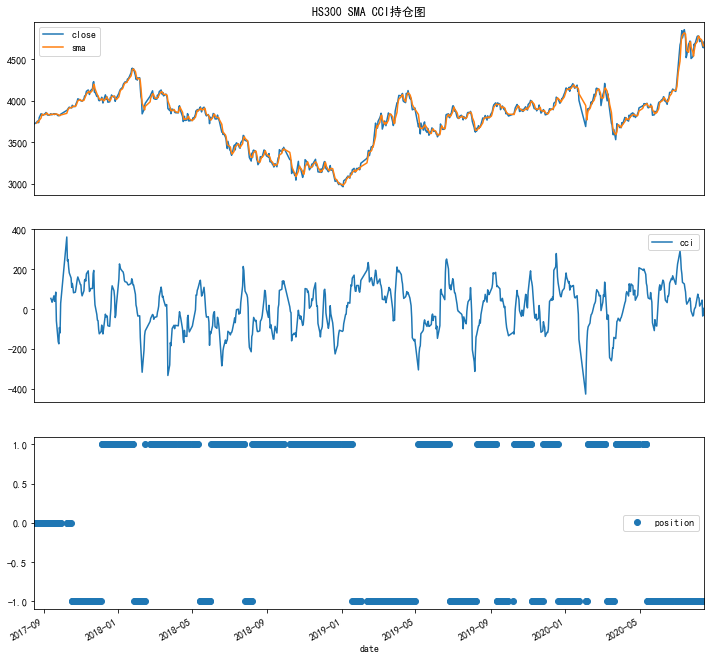

In [13]:
plt.subplot(3, 1, 1)
plt.title('HS300 SMA CCI持仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize = (12,12))
stock_index['sma'].plot()
plt.legend()

plt.subplot(3, 1, 2)
stock_index['cci'].plot(figsize = (12,12))
plt.legend()
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(3, 1, 3)
stock_index['position'].plot(marker='o', figsize=(12,12),linestyle='')
plt.legend()
plt.show()

### 3.策略收益和数据可视化

In [14]:
# 计算策略收益
# 计算股票每日收益率
stock_index['pct_change'] = stock_index['close'].pct_change()
# 计算策略每日收益率
stock_index['strategy_return'] = stock_index['pct_change'] * stock_index['position']
# 计算股票累积收益率
stock_index['return'] = (stock_index['pct_change']+1).cumprod()
# 计算策略累积收益率
stock_index['strategy_cum_return'] = (1 + stock_index['strategy_return']).cumprod()

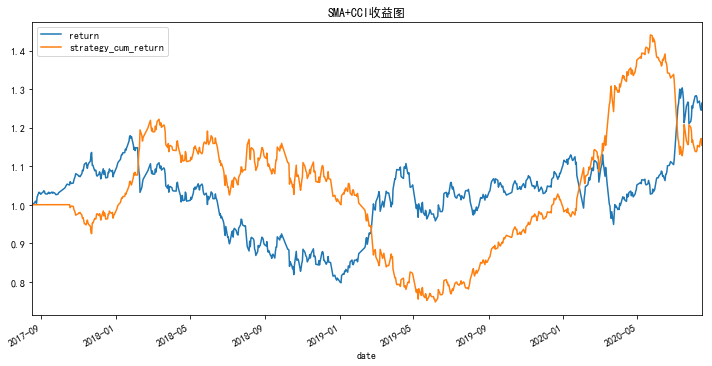

In [15]:
# 将股票累积收益率和策略累积收益率绘图
stock_index[['return', 'strategy_cum_return']].plot(figsize = (12,6))

plt.title('SMA+CCI收益图')
plt.legend()
plt.show()

In [ ]:
## 双技术为基础，三技术甚至更多指标策略指标则可构建 